In [43]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
# windows 10
# font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgunsl.ttf").get_name()
rc('font', family=font_name)           # 맑은 고딕 폰트 지정
plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import load_model

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

from keras.datasets import mnist

from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten

from keras.preprocessing.image import ImageDataGenerator

In [44]:
# 훈련용 데이터 생성기, 이미지를 데이터로 바로 사용
# rescale=1./255: 정수를 실수로 변경하기위해 픽셀값을 255로 나눔
# 이미지를 수치로 바꾸는 vector 및 정수를 실수로 변경하는 정규화 자동 지원
width=24  # 이미지 너비 픽셀
height=24 # 이미지 높이 픽셀
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        './train',
        target_size=(width, height),     # 24 x 24로 자동으로 픽셀을 줄임.
        batch_size=1,             # 이미지를 1건씩 처리
        class_mode='categorical') # 다중 분류

vali_datagen = ImageDataGenerator(rescale=1./255)
vali_generator = vali_datagen.flow_from_directory(
        './validation',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')

# Found 18 images belonging to 3 classes.
# 3개의 그룹에 모두 18개의 이미지가 존재함, 여기서 그룹은 폴더를 말함.

Found 18 images belonging to 3 classes.
Found 12 images belonging to 3 classes.


In [45]:
model = Sequential()
# 32: 마스크(커널, 필터)의 갯수
# (3, 3): 마스크(커널, 필터)의 크기
# input_shape = (width, height, 1): 24 X 24 픽셀의 Color(3) 이미지
model.add(Conv2D(32, (3, 3), input_shape = (width, height, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten()) # 2차원 텐서를 1차원 텐서로 변환

model.add(Dense(3, activation='softmax')) # 3 classes, 도형 3 종류, softmax: 다중 분류

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='loss', patience=2)

start = time.time()
hist = model.fit_generator(
        train_generator,            # 훈련 데이터
        epochs=50,                 # 학습 횟수
        validation_data=vali_generator,  # 테스트 데이터
        callbacks=[early_stopping] ) 
end = time.time()
print('Runtime: %0.2f 초' % (end-start))
# CPU: 5 s
# GPU:  , Colab GPU: , Colab,  TPU:  

Epoch 1/50
18/18 [==============================] - 1s 34ms/step - loss: 1.4901 - acc: 0.2222 - val_loss: 1.0209 - val_acc: 0.5833
Epoch 2/50
18/18 [==============================] - 0s 8ms/step - loss: 0.9629 - acc: 0.7222 - val_loss: 0.8028 - val_acc: 0.7500
Epoch 3/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5817 - acc: 0.8889 - val_loss: 0.5424 - val_acc: 0.6667
Epoch 4/50
18/18 [==============================] - 0s 10ms/step - loss: 0.2536 - acc: 1.0000 - val_loss: 0.3590 - val_acc: 0.7500
Epoch 5/50
18/18 [==============================] - 0s 8ms/step - loss: 0.1001 - acc: 1.0000 - val_loss: 0.1799 - val_acc: 1.0000
Epoch 6/50
18/18 [==============================] - 0s 10ms/step - loss: 0.0530 - acc: 1.0000 - val_loss: 0.1257 - val_acc: 1.0000
Epoch 7/50
18/18 [==============================] - 0s 7ms/step - loss: 0.0326 - acc: 1.0000 - val_loss: 0.2052 - val_acc: 0.9167
Epoch 8/50
18/18 [==============================] - 0s 9ms/step - loss: 0.0154 - acc: 1

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 22, 22, 32)        896       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 19203     
Total params: 38,595
Trainable params: 38,595
Non-trainable params: 0
_________________________________________________________________


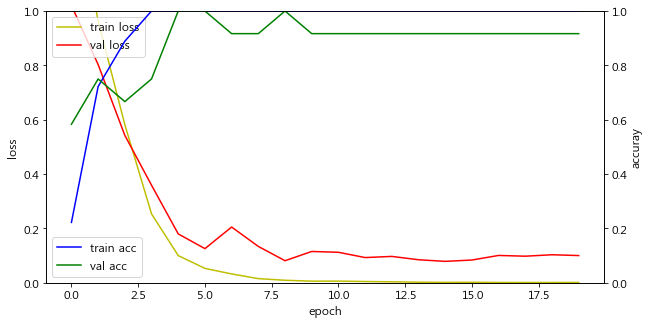

In [47]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

loss_ax.plot(hist.history['loss'], 'y', label='train loss')   # 훈련 손실
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss') # 검증 손실, 학습의 우수성 평가 척도
loss_ax.set_ylim([0.0, 1.0]) # 왼쪽 y 축, 값을 반영하여 변경

acc_ax.plot(hist.history['acc'], 'b', label='train acc')   # 훈련 정확도
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc') # 검증 정확도
acc_ax.set_ylim([0.0, 1.0])  # 오른쪽 y 축, 0 ~100 %를 의미

loss_ax.set_xlabel('epoch')  # x축 레이블
loss_ax.set_ylabel('loss')     # 왼쪽 y 레이블
acc_ax.set_ylabel('accuray') # 오른쪽 y 레이블

loss_ax.legend(loc='upper left')  # 좌측 y 축 기준 범례 위치 설정
acc_ax.legend(loc='lower left')   # 우측 y 축 기준 범례 위치 설정

plt.show()


In [48]:
print("-- Evaluate --")
scores = model.evaluate_generator(vali_generator, verbose=1)  
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
12/12 [==============================] - 0s 5ms/step
acc: 91.67%


In [49]:
print("-- Predict --")
output = model.predict_generator(vali_generator)
# 실수를 소수점 3자리까지 출력 설정
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(vali_generator.class_indices) # 그룹의 index {'circle': 0, 'rectangle': 1, 'triangle': 2}
print(type(output))
print(output.shape)
print(output)

-- Predict --
{'circle': 0, 'rectangle': 1, 'triangle': 2}
<class 'numpy.ndarray'>
(12, 3)
[[0.986 0.014 0.000]
 [0.047 0.953 0.000]
 [0.014 0.986 0.000]
 [0.003 0.997 0.000]
 [1.000 0.000 0.000]
 [0.973 0.027 0.000]
 [0.000 0.000 1.000]
 [0.998 0.002 0.000]
 [0.000 0.000 1.000]
 [0.000 0.000 1.000]
 [0.658 0.342 0.000]
 [0.020 0.980 0.000]]


In [50]:
for item in output:
    print('-----------------------')
    if (item[0] > 0.5):
        print('%6s %6s %6s' %('원','',''))     # 4
    elif (item[1] > 0.5):
        print('%6s %6s %6s' %('','사각형','')) # 5
    elif (item[2] > 0.5):
        print('%6s %6s %6s' %('','','삼각형')) # 3
    else:
        print('알수 없는 도형입니다.')

-----------------------
     원              
-----------------------
          사각형       
-----------------------
          사각형       
-----------------------
          사각형       
-----------------------
     원              
-----------------------
     원              
-----------------------
                 삼각형
-----------------------
     원              
-----------------------
                 삼각형
-----------------------
                 삼각형
-----------------------
     원              
-----------------------
          사각형       


In [51]:
# 최대값의 index를 찾아줌으로 정확도가 높음
for item in output:
    print('-----------------------')
    idx = np.argmax(item) # 0 ~ 2
    
    if (idx == 0):
        print('%6s %6s %6s' %('원','',''))     # 4
    elif (idx == 1):
        print('%6s %6s %6s' %('','사각형','')) # 5
    elif (idx == 2):
        print('%6s %6s %6s' %('','','삼각형')) # 3

-----------------------
     원              
-----------------------
          사각형       
-----------------------
          사각형       
-----------------------
          사각형       
-----------------------
     원              
-----------------------
     원              
-----------------------
                 삼각형
-----------------------
     원              
-----------------------
                 삼각형
-----------------------
                 삼각형
-----------------------
     원              
-----------------------
          사각형       


In [52]:
def display1(data): # 2차원 배열(2차원 텐서) 
    print(data)
    print(type(data))
    sw = 0
    if data[0][0] > 0.5:
        sw = '원'
    elif data[0][1] > 0.5:
        sw = '사각형'
    elif data[0][2] > 0.5:
        sw = '삼각형'
    else:
        sw = '알수없는 도형'
        
    return sw    
 
def display2(data):   # argmax를 사용하는 2차원 배열(2차원 텐서) 
    # print(data.shape)
    # print(data[0])
    # print(type(data[0]))
    sw= np.argmax(data[0], axis=0) # 0:열, 1: 행
    # print('sw:', sw)
 
    if sw == 0:
        sw = '원'
    elif sw == 1:
        sw = '사각형'
    elif sw == 2:
        sw = '삼각형'
        
    return sw     

def display3(data):  # argmax를 사용하는 1차원 배열(1차원 텐서)
    # print(data.shape)
    # print(data)
    # print(type(data))
    sw= np.argmax(data, axis=0) # 0:열, 1: 행
    # print('sw:', sw)
 
    if sw == 0:
        sw = '원'
    elif sw == 1:
        sw = '사각형'
    elif sw == 2:
        sw = '삼각형'
        
    return sw     

In [53]:
model.save('./shape.h5')

In [54]:
model = load_model('./shape.h5')

In [56]:
# 테스트
use_datagen = ImageDataGenerator(rescale=1./255)
use_generator = use_datagen.flow_from_directory('./use1', target_size=(24, 24),    
                      batch_size=1, class_mode='categorical')
output = model.predict_generator(use_generator)
print(output.shape)
print('원', display1(output))
print('원', display2(output))

Found 1 images belonging to 1 classes.
(1, 3)
[[0.913 0.085 0.002]]
<class 'numpy.ndarray'>
원 원
원 원


In [57]:
use_datagen = ImageDataGenerator(rescale=1./255)
use_generator = use_datagen.flow_from_directory('./use2', target_size=(24, 24),    
        batch_size=1, class_mode='categorical')
output = model.predict_generator(use_generator)
print(output.shape)
print('사각형', display1(output))
print('사각형', display2(output))

Found 1 images belonging to 1 classes.
(1, 3)
[[0.057 0.943 0.000]]
<class 'numpy.ndarray'>
사각형 사각형
사각형 사각형


In [58]:
use_datagen = ImageDataGenerator(rescale=1./255)
use_generator = use_datagen.flow_from_directory('./use3', target_size=(24, 24),    
        batch_size=1, class_mode='categorical')
output = model.predict_generator(use_generator)
print(output.shape)
print('삼각형', display1(output))
print('삼각형', display2(output))

Found 1 images belonging to 1 classes.
(1, 3)
[[0.007 0.002 0.992]]
<class 'numpy.ndarray'>
삼각형 삼각형
삼각형 삼각형


In [59]:
use_datagen = ImageDataGenerator(rescale=1./255)
use_generator = use_datagen.flow_from_directory('./use4', target_size=(24, 24),    
        batch_size=1, class_mode='categorical')
output = model.predict_generator(use_generator)
print(output.shape)
print('원', display1(output))
print('원', display2(output))

Found 1 images belonging to 1 classes.
(1, 3)
[[0.952 0.045 0.003]]
<class 'numpy.ndarray'>
원 원
원 원


In [60]:
use_datagen = ImageDataGenerator(rescale=1./255)
use_generator = use_datagen.flow_from_directory('./use5', target_size=(24, 24),    
        batch_size=1, class_mode='categorical')
output = model.predict_generator(use_generator)
print(output.shape)
print('사각형', display1(output))
print('사각형', display2(output))

Found 1 images belonging to 1 classes.
(1, 3)
[[0.396 0.478 0.126]]
<class 'numpy.ndarray'>
사각형 알수없는 도형
사각형 사각형


In [62]:
# 실제 이미지와 학습이미의 크기가 많이 다르면 픽셀이 분실됨.
use_datagen = ImageDataGenerator(rescale=1./255)
use_generator = use_datagen.flow_from_directory('./use6', target_size=(24, 24),    
        batch_size=1, class_mode='categorical')
output = model.predict_generator(use_generator)
print(output.shape)
print('삼각형', display1(output))
print('삼각형', display2(output))

Found 1 images belonging to 1 classes.
(1, 3)
[[0.433 0.312 0.255]]
<class 'numpy.ndarray'>
삼각형 알수없는 도형
삼각형 원
